In [48]:
%load_ext autoreload
%autoreload 2
from mapvbvd import mapVBVD
from pathlib import Path
import numpy as np
import h5py
import datetime
import json
import nibabel as nib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [3]:
supressed_file = Path('original_data/meas_MID310_STEAM_metab_FID115673.dat')
unsupressed_file = Path('original_data/meas_MID312_STEAM_wref3_FID115675.dat')

suppressed_raw = mapVBVD(supressed_file,quiet=True)
unsuppressed_raw = mapVBVD(unsupressed_file,quiet=True)

### Extract data

In [4]:
suppressed_raw.image.removeOS=False
unsuppressed_raw.image.removeOS=False
supp_block = suppressed_raw.image.unsorted()
unsupp_block = unsuppressed_raw.image.unsorted()

newshape = (1,1,1)+supp_block.shape
supp_block = supp_block.reshape(newshape)

newshape = (1,1,1)+unsupp_block.shape
unsupp_block = unsupp_block.reshape(newshape)


In [5]:
unsupp_block.shape

(1, 1, 1, 4096, 32, 2)

In [6]:
import matplotlib.pyplot as plt

plt.plot(np.real(unsupp_block[0,0,0,:,0,0]))
plt.plot(np.imag(unsupp_block[0,0,0,:,0,0]))
plt.plot(np.abs(unsupp_block[0,0,0,:,0,0]))
plt.show()

<Figure size 640x480 with 1 Axes>

### Voxel orientation calculations 
From spec2nii code

In [7]:
from spec2nii.twixfunctions import twix2DCMOrientation,examineTwix,extractTwixMetadata
from spec2nii.dcm2niiOrientation.orientationFuncs import nifti_dicom2mat
from spec2nii.nifti_orientation import NIFTIOrient

# Orientation calculations
#1) Calculate dicom like imageOrientationPatient,imagePositionPatient,pixelSpacing and slicethickness
imageOrientationPatient,imagePositionPatient,pixelSpacing,slicethickness = twix2DCMOrientation(suppressed_raw['hdr'],False)

# 2) in style of dcm2niix
# a) calculate Q44
xyzMM = np.append(pixelSpacing,slicethickness)
Q44 = nifti_dicom2mat(imageOrientationPatient,imagePositionPatient,xyzMM,verbose=False)
# b) calculate nifti quaternion parameters
Q44[:2,:] *= -1
# qb,qc,qd,qx,qy,qz,dx,dy,dz,qfac = nifti_mat44_to_quatern(Q44)
# 3) place in data class for nifti orientation parameters  
currNiftiOrientation = NIFTIOrient(Q44)


In [8]:
print(currNiftiOrientation.Q44)

[[ 20.          -0.          -0.         -32.90067836]
 [ -0.         -20.          -0.          10.6633755 ]
 [  0.           0.         -20.          21.35589036]
 [  0.           0.           0.           1.        ]]


### Meta data
#### Dimension information

In [9]:
dim_dict = {'dim_5': 'DIM_COIL',
            'dim_6': 'DIM_DYN',
            'dim_6_use': 'Signal repetitions'}

#### Required for Minimum conformance
**TransmitterFrequency** , Array of doubles, See DICOM tag (0018,9098). Should be given in MHz.  
**ResonantNucleus**, Array of strings, See DICOM tag (0018,9100). Must be one of the DICOM recognised nuclei “1H”, “3HE”, “7LI”, “13C”, “19F”, “23NA”, “31P”, “129XE” or one named in the specified format. I.e. Mass number followed by the chemical symbol in uppercase.  

__Stored in pixdim[4]__  
**Dwelltime**, Should be given in s.  

In [12]:
dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9 # For nifti pixel dim
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
nucleus_str = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'tNucleus')].strip('"')

print(f'TransmitterFrequency = {transmitter_frequency_mhz:0.6f} MHz')
print(f'ResonantNucleus = {nucleus_str}')
print(f'dwelltime = {dwelltime:0.2e} s')


TransmitterFrequency = 297.219948 MHz
ResonantNucleus = 1H
dwelltime = 8.33e-05 s


#### Extract some optional metadata as well 

Incude:  
**EchoTime**, double, Time from centroid of excitation to start of FID or centre of echo. Units: Seconds  
**RepetitionTime**, double, Sequence repetition time. Units: Seconds  
**InversionTime**, double, Inversion time. Units: Seconds  
**MixingTime**, double, Mixing time in e.g. STEAM sequence. Units: Seconds


**ConversionMethod**, String, Program used for conversion. May include additional information like software version.  
**ConversionTime**, String:  “YYYY-MM-DDThh:mm:ss.sss”, Time and date of conversion. ISO 8601 compliant format  
**OriginalFile**, String, Name and extension of the original file  



Not included:  
**SaturationBands**, Array of 2D 4x4 arrays, Orientation/position affine for each saturation band

In [24]:
echo_time_s = suppressed_raw['hdr']['MeasYaps'][('alTE', '0')]/1E6
repetition_time_s = suppressed_raw['hdr']['MeasYaps'][('alTR', '0')]/1E6
inversion_time_s = None
mixing_time_s = suppressed_raw['hdr']['MeasYaps'][('alTD', '0')]/1E6

print(f'EchoTime = {echo_time_s:0.3f} s')
print(f'RepetitionTime = {repetition_time_s:0.3f} s')
print(f'InversionTime = {inversion_time_s} s')
print(f'MixingTime = {mixing_time_s:0.3f} s')

conversion_method = 'Manual'
conversion_time = datetime.datetime.now().isoformat(sep='T',timespec='milliseconds')
original_file = [str(supressed_file.name)]

print(f'ConversionMethod = {conversion_method}')
print(f'ConversionTime = {conversion_time}')
print(f'OriginalFile = {original_file}')

EchoTime = 0.011 s
RepetitionTime = 5.000 s
InversionTime = None s
MixingTime = 0.032 s
ConversionMethod = Manual
ConversionTime = 2020-11-20T08:20:51.208
OriginalFile = ['meas_MID310_STEAM_metab_FID115673.dat']


## Make the json string 

In [36]:
metadata_dict_required = {**dim_dict,
                          'TransmitterFrequency':transmitter_frequency_mhz,
                          'ResonantNucleus':nucleus_str}

json_min = json.dumps(metadata_dict_required)
print(json_min)

metadata_dict = {**metadata_dict_required,
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime': conversion_time,
                'OriginalFile': original_file}

json_full= json.dumps(metadata_dict)
print(json_full)


{"dim_5": "DIM_COIL", "dim_6": "DIM_DYN", "dim_6_use": "Signal repetitions", "TransmitterFrequency": 297.219948, "ResonantNucleus": "1H"}
{"dim_5": "DIM_COIL", "dim_6": "DIM_DYN", "dim_6_use": "Signal repetitions", "TransmitterFrequency": 297.219948, "ResonantNucleus": "1H", "EchoTime": 0.011, "RepetitionTime": 5.0, "InversionTime": null, "MixingTime": 0.032, "ConversionMethod": "Manual", "ConversionTime": "2020-11-20T08:20:51.208", "OriginalFile": ["meas_MID310_STEAM_metab_FID115673.dat"]}


## Data conventions
- The spectral data points are ordered in sequence of increasing time and contain the value TIME.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time):  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.

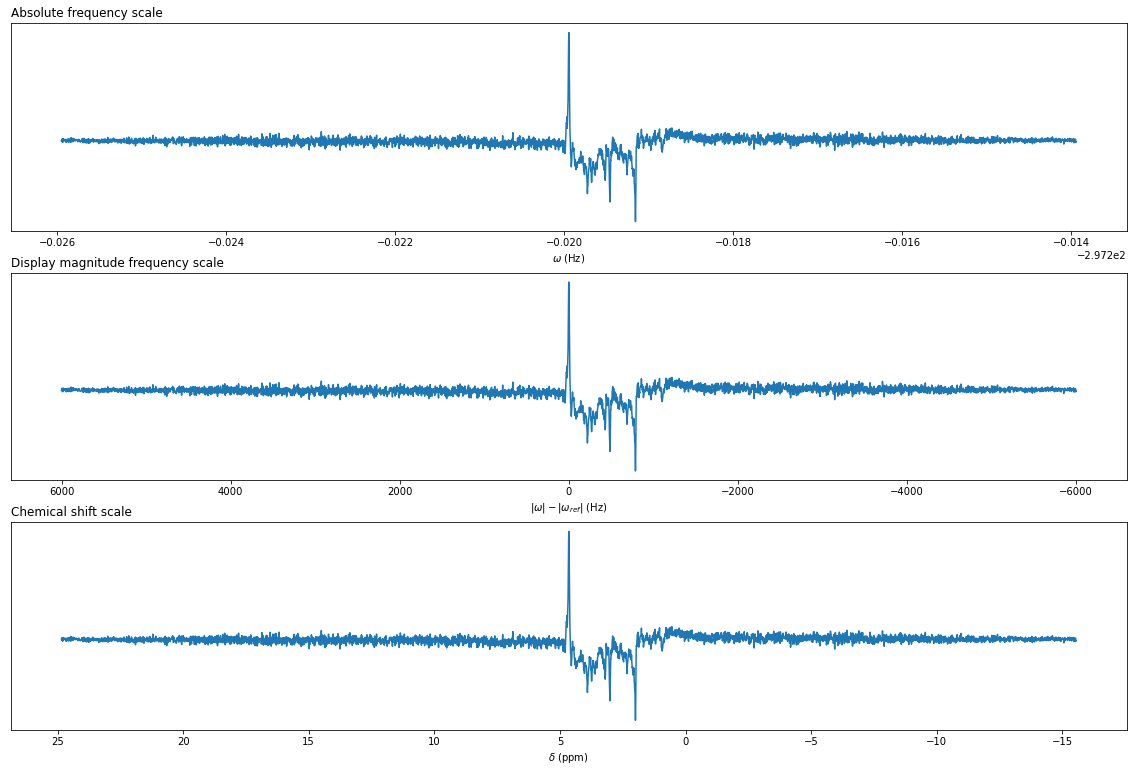

In [31]:
supp_block = supp_block.conj()
unsupp_block = unsupp_block.conj()

# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
spectral_width_hz = 1/dwelltime
npoints = supp_block.shape[3]
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = 4.65+ frequency_axis/transmitter_frequency_mhz

test_FID = np.mean(supp_block[0,0,0,:,0,:],axis=1)

spec_fft = np.fft.fftshift(np.fft.fft(test_FID))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

## Write the nifti file 

In [37]:
save_path = Path('./example_data/svs_1')

newobj = nib.nifti2.Nifti2Image(supp_block,currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set conformance level 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_full.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_suppressed.nii.gz')

### Repeat for minimum conformance 

In [38]:
newobj = nib.nifti2.Nifti2Image(supp_block,currNiftiOrientation.Q44)

pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set conformance level 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_min.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_suppressed_min.nii.gz')

### And unsuppressed

In [39]:
newobj = nib.nifti2.Nifti2Image(unsupp_block,currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set conformance level 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_full.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_unsuppressed.nii.gz')

## Use data from fsl_mrs example as combined

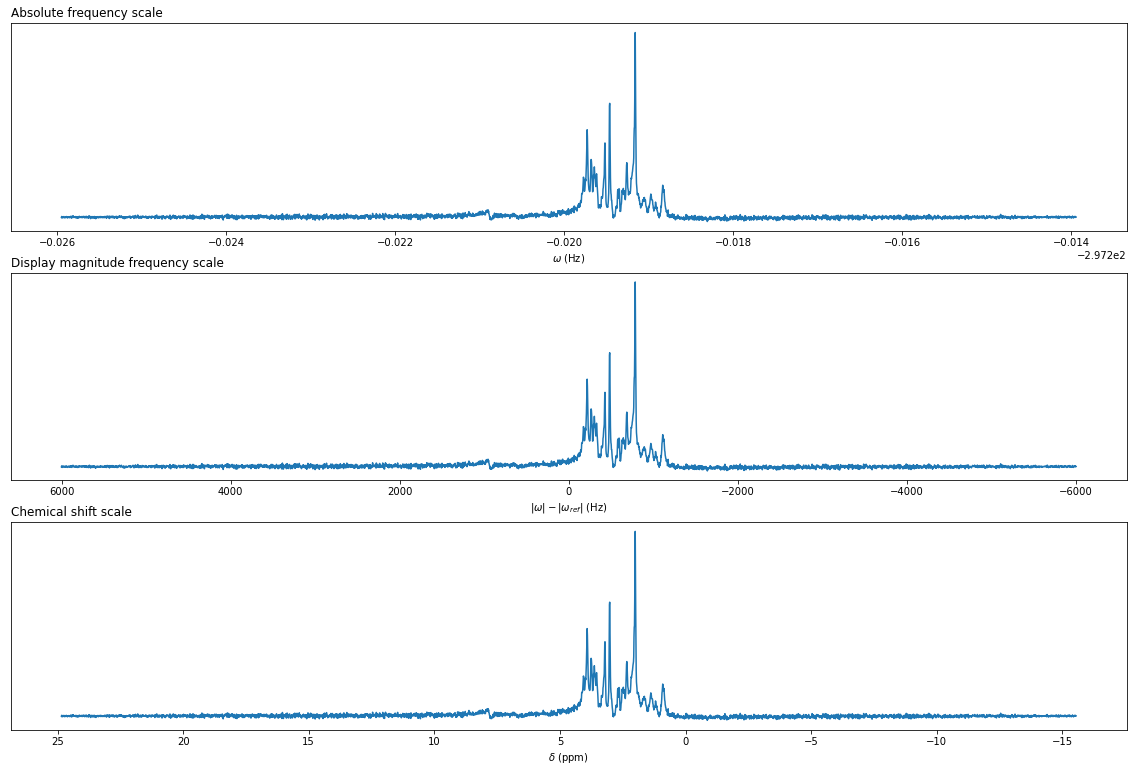

In [44]:
combined_data = nib.load('original_data/metab.nii')
combined_data_values = combined_data.get_fdata(dtype=np.complex64)
combined_data_values = combined_data_values.conj()
combined_data_values = np.pad(combined_data_values,((0,0),(0,0),(0,0),(0,1))) # Zero pad to correct odd number of points

spec_fft = np.fft.fftshift(np.fft.fft(combined_data_values[0,0,0,:]))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

combined_data_out = nib.nifti2.Nifti2Image(combined_data_values,currNiftiOrientation.Q44)

pixDim = combined_data_out.header['pixdim']
pixDim[4] = dwelltime
combined_data_out.header['pixdim'] = pixDim

# Set q_form >0
combined_data_out.header.set_qform(currNiftiOrientation.Q44)

min_dict_preproc = {'TransmitterFrequency':transmitter_frequency_mhz,
                    'ResonantNucleus':nucleus_str}

dict_preproc = {**min_dict_preproc,
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime': conversion_time,
                'OriginalFile': original_file}

json_preproc = json.dumps(dict_preproc)

# Set conformance level 
combined_data_out.header['intent_name'] = b'mrs_v0_2'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_preproc.encode('UTF-8'))
combined_data_out.header.extensions.append(extension)

# # From nii obj and write    
nib.save(combined_data_out,save_path / 'svs_preprocessed.nii.gz')

### Save out hdf5 versions of data

In [45]:
with h5py.File(save_path / 'data.h5', 'w') as h5f:
    h5f.create_dataset('svs_suppressed', data=supp_block)
    h5f.create_dataset('svs_suppressed_min', data=supp_block)
    h5f.create_dataset('svs_unsuppressed', data=unsupp_block)
    h5f.create_dataset('svs_preprocessed', data=combined_data_values)

## Load and check 

In [46]:
check_nifti = nib.load(save_path / 'svs_suppressed.nii.gz')

with h5py.File(save_path / 'data.h5','r') as h5f:
    check_hdf5 = h5f['svs_suppressed'][:]
    
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),supp_block)
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),check_hdf5)

loaded_he_content = json.loads(check_nifti.header.extensions[0].get_content())

assert loaded_he_content == metadata_dict


In [47]:
print(check_nifti.header)

<class 'nibabel.nifti2.Nifti2Header'> object, endian='<'
sizeof_hdr      : 540
magic           : b'n+2'
eol_check       : [13 10 26 10]
datatype        : complex64
bitpix          : 64
dim             : [   6    1    1    1 4096   32   64    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
pixdim          : [1.00e+00 2.00e+01 2.00e+01 2.00e+01 8.33e-05 1.00e+00 1.00e+00 1.00e+00]
vox_offset      : 0
scl_slope       : nan
scl_inter       : nan
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
slice_start     : 0
slice_end       : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 1.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -32.90067836
qoffset_y       : 10.6633755
qoffset_z       : 21.35589036
srow_x          : [ 20.          -0.          -0.         -32.90067836]
srow_y          : [ -0.        -20.         -0.         10.6633755]
srow_z       